In [1]:
from read_write_mrc import read_mrc
import torch
import torch.optim as optim
import torch.nn as nn
import numpy as np
from sliceloader import SliceLoader
from torch.utils.data import DataLoader
from pytorch_network import UNet
import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(input_shape=(1, 64, 704, 704), num_classes=2)
model = nn.DataParallel(model)
model.load_state_dict(torch.load("pytorch_models_1_class"))
model = model.to(device)

In [3]:
img = read_mrc('slices/mrc_val/KLW_PBC_INS1e_Ex-4_5min_1111_8_pre_rec_final_14.mrc')
y = read_mrc('slices/mask_val/KLW_PBC_INS1e_Ex-4_5min_1111_8_pre_rec_final_labels14.mrc')

i = 18

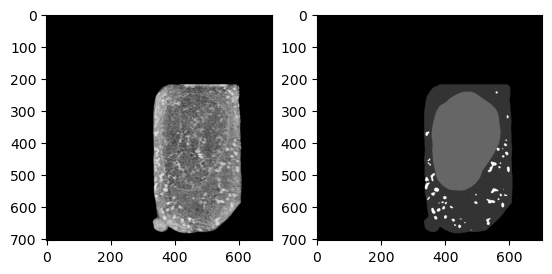

In [4]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(img[i,:,:], cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(y[i,:,:], cmap = "gray")
plt.show()

In [5]:
img = np.expand_dims(img, axis=(0,1))
y = np.where((y == 5), np.ones(y.shape), np.zeros(y.shape))
y = np.expand_dims(y, axis=0)
y = np.stack((y,np.where((y == 0), np.ones(y.shape), np.full(y.shape, 0.0) )), 1)
print(img.shape)
print(y.shape)

(1, 1, 64, 704, 704)
(1, 2, 64, 704, 704)


In [6]:
img = torch.from_numpy(img)
model = model.to(torch.device("cuda"))
y_pred = model(img)
y_pred = y_pred.to(torch.device("cpu"))
y_pred = y_pred.detach().numpy()

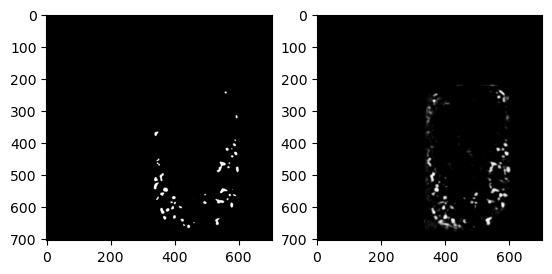

In [7]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(y[0,0,i,:,:], cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(y_pred[0,0,i,:,:], cmap = "gray")
plt.show()

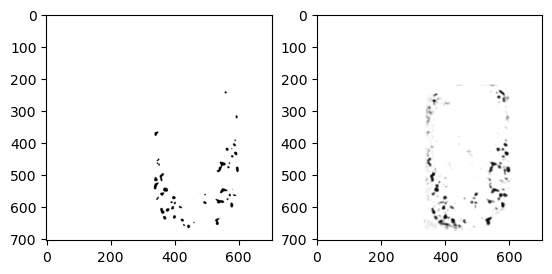

In [8]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(y[0,1,i,:,:], cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(y_pred[0,1,i,:,:], cmap = "gray")
plt.show()

In [9]:
print(np.unique(y_pred))
print(np.unique(y))

[5.6979168e-08 6.9933606e-08 7.5566369e-08 ... 9.9999976e-01 9.9999988e-01
 1.0000000e+00]
[0. 1.]


In [10]:
print(np.count_nonzero(img), np.count_nonzero(y), np.count_nonzero(y_pred) )

7528634 31719424 63438848


In [11]:
y_pred = np.where((y_pred>0.5), np.ones(y_pred.shape), np.zeros(y_pred.shape)  )
print(np.unique(y_pred))
print(np.unique(y))

[0. 1.]
[0. 1.]


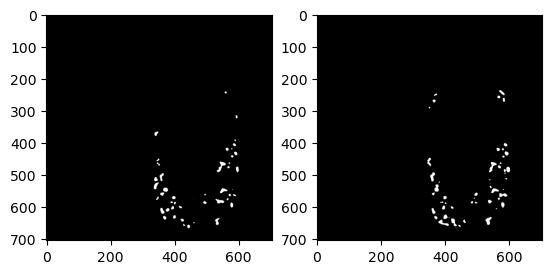

In [12]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(y[0,0,i,:,:], cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(y_pred[0,0,i,:,:], cmap = "gray")
plt.show()

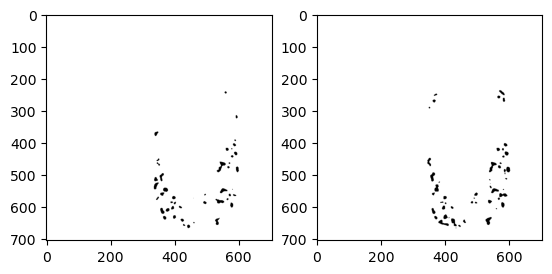

In [13]:
plt.figure()
plt.subplot(1,2,1)
plt.imshow(y[0,1,i,:,:], cmap = "gray")
plt.subplot(1,2,2)
plt.imshow(y_pred[0,1,i,:,:], cmap = "gray")
plt.show()

In [14]:
def accuracy(preds, label):
    valid = (label > 0)
    acc_sum = (valid * (preds == label)).sum()
    valid_sum = valid.sum()
    acc = float(acc_sum) / (float(valid_sum) + 1e-10)
    return acc

def IOU_dice(imPred, imLab, numClass):
    # imPred = np.asarray(imPred.cpu()).copy()
    # imLab = np.asarray(imLab.cpu()).copy()
    eps = 1
    # Remove classes from unlabeled pixels in gt image.
    # We should not penalize detections in unlabeled portions of the image.
    # imPred = imPred * (imLab > 0)

    # Compute area intersection:
    intersection = imPred * (imPred == imLab)
    (area_intersection, _) = np.histogram(intersection, bins=numClass - 1, range=(1, numClass - 1))

    # Compute area union:
    # We don't need background
    (area_pred, _) = np.histogram(imPred, bins=numClass - 1, range=(1, numClass - 1))  # 1, 2, 3, 4
    (area_lab, _) = np.histogram(imLab, bins=numClass - 1, range=(1, numClass - 1))
    area_union = area_pred + area_lab - area_intersection

    IOU = (area_intersection + eps) / (area_union + eps)
    Dice = (2 * area_intersection + eps) / (area_pred + area_lab + eps)

    return IOU, Dice

In [15]:
print(accuracy(y_pred, y), IOU_dice(y_pred, y ,2)[0], IOU_dice(y_pred, y,2)[1] )

0.9944729135056173 [0.98900659] [0.99447291]


In [16]:
val_dataset = SliceLoader("slices", "mrc_val", "mask_val")
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

In [ ]:
for x,y in val_loader:
    y = y.detach().numpy()
    y_pred = model(x)
    y_pred = y_pred.to(torch.device("cpu"))
    y_pred = y_pred.detach().numpy()
    y_pred = np.where((y_pred>0.5), np.ones(y_pred.shape), np.zeros(y_pred.shape)  )
    print(accuracy(y_pred, y), IOU_dice(y_pred, y,2)[0], IOU_dice(y_pred, y,2)[1] )

0.9978793908741849 [0.99576776] [0.99787939]
0.994370941288215 [0.9888049] [0.99437094]
0.9961537684290862 [0.99233701] [0.99615377]
1.0 [1.] [1.]
1.0 [1.] [1.]
0.9982413930341232 [0.99648896] [0.99824139]
0.9971709054363661 [0.99435778] [0.99717091]
0.996246826550192 [0.99252172] [0.99624683]
0.9963192663902094 [0.99266553] [0.99631927]
0.9997752796519886 [0.99955066] [0.99977528]
1.0 [1.] [1.]
0.9998172413219105 [0.99963455] [0.99981724]
0.9939210749854727 [0.98791561] [0.99392108]
0.9946918566364887 [0.98943977] [0.99469186]
0.9997592484655459 [0.99951861] [0.99975925]
0.9998357709774301 [0.9996716] [0.99983577]
0.996494151343984 [0.9930128] [0.99649415]
0.9930956265157904 [0.98628594] [0.99309563]
0.998832678991901 [0.99766808] [0.99883268]
1.0 [1.] [1.]
0.9998813975941051 [0.99976282] [0.9998814]
0.994682784908074 [0.98942182] [0.99468278]
0.9952642897929042 [0.99057322] [0.99526429]
0.9983017267274462 [0.99660921] [0.99830173]
0.9997012319643636 [0.99940264] [0.99970123]
1.0 [1.]